In [1]:
# Gautam Jain, Jannis Horn 

%matplotlib notebook
import time
import os
import itertools
from typing import Tuple
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch  
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as topt
import wandb
import cv2
import os
from torchvision.transforms import ToTensor
import torchvision.models as models
from torchviz import make_dot
%matplotlib inline

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print( torch.__version__ )
seed = np.random.randint( 2**16 )
torch.manual_seed( seed )
print( "seed={}".format(seed) )
# 36232
print(device)
recompute = False

1.8.1
seed=10860
cuda


In [2]:
import pickle
import cv2
import os
import numpy as np
import random
from pytube import YouTube

vids = [
    #"https://www.youtube.com/watch?v=yyLa6xIK9Qs",
    #"https://www.youtube.com/watch?v=_bR-usQb4UE",
    #"https://www.youtube.com/watch?v=ITe-seb4PsA",
    #"https://www.youtube.com/watch?v=TPgRR3HoSDw",
    #"https://www.youtube.com/watch?v=qmYSt3nVJpA",
    #"https://www.youtube.com/watch?v=tPktQyFrMuw",
    #"https://www.youtube.com/watch?v=IwWt8CS_oBg",
    #"https://www.youtube.com/watch?v=UsmBD2_3FH8",
    #"https://www.youtube.com/watch?v=h4Kds-RiuYM",
    #"https://www.youtube.com/watch?v=9FvMW2PcBeA",
    #"https://www.youtube.com/watch?v=5w2tdfEQzac",
    #"https://www.youtube.com/watch?v=WGKo_6IkFBY",
    #"https://www.youtube.com/watch?v=sL-BEltQy9k",
    #"https://www.youtube.com/watch?v=qk4qXXJcaZk",
    #"https://www.youtube.com/watch?v=NlrEaU50Mw4"
    ]

test_vids = ["https://www.youtube.com/watch?v=yVdB_0ry53o"]

def downloadStream(vid, temp_pt):
    yt = YouTube(vid)
    # print(yt.streams.filter( mime_type="video/mp4", progressive=False, res="240p" ))
    print( "Got: {}".format( yt.title ) )
    stream = yt.streams.filter(mime_type="video/mp4", progressive=False, res="720p")[0]
    fps = stream.fps
    l = yt.length
    num_frames = fps * l
    dt_n = stream.download(output_path=temp_pt, skip_existing=True)
    print( "Got: {}".format(dt_n) )
    return dt_n, num_frames


def subsequenceVideo(fn, n_fr, out_size):
    print(fn)
    cap = cv2.VideoCapture(fn)
    val_fr = False
    out = []
    fr = 1
    while (cap.isOpened()):
        if fr%1000 == 0:
            print( "{}/{}".format(fr, n_fr), end="\r" )
        ret, frame = cap.read()
        if ret == False:
            break
        out.append( resizeIm( frame, out_size ) )
        fr += 1

    cap.release()
    cv2.destroyAllWindows()
    return [np.stack( out, axis=0 )]


def resizeIm( frame, out_size ):
    out = cv2.resize( frame, out_size, interpolation=cv2.INTER_CUBIC )
    out = np.swapaxes( out, 0, 2 )
    return out


def saveSeqs( path, seqs, st ):
    for it, seq in enumerate(seqs):
        pt = os.path.join( path, "seq_{}".format( st+it ) )
        np.savez( pt, seq )
    return st+it+1


temp_pt = os.path.expanduser("~/temp/")
out_path = os.path.expanduser( "~/Documents/robot_gifs/" )
if recompute:
    dims = ( 320, 224 )
    seq_num = 0
    for vid in vids:
        try:
            dt_n, n_fr = downloadStream( vid, temp_pt )
            seqs = subsequenceVideo( dt_n, n_fr, dims )
            print(seqs[0].shape)
            seq_num = saveSeqs( out_path, seqs, seq_num )
            del seqs
        except Exception as e:
            print(e)
            continue


In [3]:
out_split = os.path.expanduser( "~/Documents/robot_test/" )
mlength = 100
g_it = 0

def splitVideoNp( path, vid_np, max_length, cur_seq_it ):
    global g_it
    length = vid_np.shape[0]
    splits = np.arange( 0, length, max_length )
    splitl = []
    if splits[-1] != length: splits = np.append( splits, length )
    for it in range(len(splits[:-1])):
        cur_seq = vid_np[splits[it]:min(splits[it+1]+6, length)]
        if g_it == 20:
            plt.imshow( np.flip( np.swapaxes( cur_seq[10], 0,2 ),axis=2 ) )
            plt.show()
            g_it = 0
        g_it += 1
        np.savez( os.path.join( path, "seq_{}.npz".format( cur_seq_it+it ) ), cur_seq )
        splitl.append( cur_seq.shape[0] )
    return cur_seq_it +len(splits[:-1]), splitl

if recompute:
    splitl = []
    cur_seq_it = 0    
    for vid in os.listdir( out_path ):
        fp = os.path.join( out_path, vid )
        if os.path.isfile( fp ) and "test_" in fp:
            print( cur_seq_it )
            arr = np.load( fp )["arr_0"]
            cur_seq_it, ls = splitVideoNp( out_split, arr, mlength, cur_seq_it )
            splitl += ls
            print(ls)
            del arr
    np.savez( os.path.join( out_split, "seq_lengths.npz"), np.array(splitl ) )

In [4]:
green = [0, 153, 51]
red = [0,0,204]

class Logger:
    
    def __init__( self, prefix ):
        self.cur_ep = 0
        self.prefix = prefix
        
    def plot( self, loss, loss_pim, time, epoch=-1 ):
        if epoch == -1:
            self.cur_ep += 1
        else: self.cur_ep = epoch
        wandb.log( {"{}_Loss".format( self.prefix ): loss,
                    "{}_Time".format( self.prefix ): time,
                    "{}_Loss Im1".format( self.prefix ): loss_pim[0],
                    "{}_Loss Im2".format( self.prefix ): loss_pim[1],
                    "{}_Loss Im3".format( self.prefix ): loss_pim[2]},
                   step=self.cur_ep )
        
    def plotTr( self, loss, lr, time, epoch=-1 ):
        if epoch == -1:
            self.cur_ep += 1
        else: self.cur_ep = epoch
        wandb.log( {"{}_Loss".format( self.prefix ): loss,
                    "{}_Time".format( self.prefix ): time,
                    "{}_lr".format( self.prefix ): lr},
                   step=self.cur_ep )
        
    def plotImages( self, teacher_ims, out_ims, fps=4, epoch=-1 ):
        if epoch == -1:
            self.cur_ep += 1
        else: self.cur_ep = epoch
        print(teacher_ims.shape)
        self._logGif( "{}_out".format( self.prefix ), self._getGif( teacher_ims, out_ims ), fps )
       
    def _getGif( self, teacher_ims, out_ims ):
        gifs = []
        for bt_it in range( teacher_ims.shape[0] ):
            t_gif = np.stack( [self._drawOutline(im, red, 4) for im in self._toRGB(teacher_ims[bt_it,:,:,:,:]) ], axis=0 )
            o_gif = np.stack( [self._drawOutline(im, red, 4) for im in self._toRGB(teacher_ims[bt_it,:3,:,:,:]) ]
                              +[self._drawOutline(im, green, 4) for im in self._toRGB(out_ims[bt_it,:,:,:,:]) ], axis=0 )
            gifs.append( self._combineGifs( t_gif, o_gif ) )
        return np.flip( np.concatenate( gifs, axis=2 ), axis=1 )
    
    def _drawOutline( self, im, clr, outline_size ):
        pad_im = np.empty( [im.shape[0],
                            im.shape[1]+2*outline_size,
                            im.shape[2]+2*outline_size] )
        for ch in range(3):
            pad_im[ch,:,:] = np.pad( im[ch,:,:], pad_width=outline_size, mode='constant', constant_values=clr[ch] )
        return np.swapaxes( pad_im, 1,2 )
     
    def _combineGifs( self, gif1, gif2 ):
        out = []
        for im1, im2 in zip( gif1, gif2 ):
            out_im = np.zeros( [3, gif1.shape[-2], gif1.shape[-1]*2+1], dtype=np.uint8 )
            out_im[:,:,:gif1.shape[-1]] = im1
            out_im[:,:,gif1.shape[-1]+1:] = im2
            out.append( out_im )
        return np.stack(out, axis=0)
    
    def _toRGB( self, im ):
        im = (im+1) *125.5
        return im.astype( np.uint8 )
    
    def _logGif( self, key, ims, fps ):
        wandb.log( {key: wandb.Video( ims, fps=fps )}, 
                   step=self.cur_ep )
        

In [5]:
#convGRU code taken from: https://github.com/SreenivasVRao/ConvGRU-ConvLSTM-PyTorch/blob/master/convgru.py
from convgru import ConvGRU

#DSSIM Loss taken from: https://github.com/Po-Hsun-Su/pytorch-ssim/blob/master/pytorch_ssim/__init__.py
from dssim import SSIM

In [6]:
class LadderLayer( nn.Module ):
    def __init__( self, w, h, in_channels, out_channels, use_loc_dep ):
        super( LadderLayer, self ).__init__()
        if not use_loc_dep: self.conv = nn.Conv2d( in_channels, out_channels, (1,1) )
        else: self.conv = LocationAwareConv2d( True, False, w, h, in_channels, out_channels, (1,1) )
        self.conv_gru3 = ConvGRU( in_channels, out_channels, (3,3), 1, batch_first=True )
        self.conv_gru5 = ConvGRU( in_channels, out_channels, (5,5), 1, batch_first=True )
        self.conv_gru7 = ConvGRU( in_channels, out_channels, (7,7), 1, batch_first=True )
        
    def forward( self, x, h ):
        out_l = []
        if h is None: h = [None, None, None]
        for it in range( x.shape[1] ):
            out_l.append( self.conv( x[:,it,:,:,:] ) )
        out = torch.stack( out_l, dim=1 )
        out3,h3 = self.conv_gru3( x, h[0] )
        out5,h5 = self.conv_gru5( x, h[1] )
        out7,h7 = self.conv_gru7( x, h[2] )
        return torch.cat( [out, out3[0], out5[0], out7[0]], dim=2 ), [h3, h5, h7]
        
        
class ReconstructionLayer( nn.Module ):
    def __init__( self, in_channels, use_btnorm ):
        super( ReconstructionLayer, self ).__init__()
        if not use_btnorm: self.relu = nn.ReLU()
        else: self.relu = nn.Sequential( nn.ReLU(), nn.BatchNorm2d( in_channels ) )
        self.conv1 = nn.Conv2d( in_channels, 1024, (3,3), padding=1 )
        self.shuffle = nn.PixelShuffle( 2 )
        self.conv2 = nn.Conv2d( 256, 64, (3,3), padding=1 )
        
    def forward( self, x ):
        out = self.relu( x )
        out = self.conv1( out )
        out = self.shuffle( out )
        out = self.conv2( out )
        return out
        
        
class LocationAwareConv2d(torch.nn.Conv2d):
    def __init__(self,locationAware,gradient,w,h,in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        if locationAware:
            self.locationBias=torch.nn.Parameter(torch.zeros(w,h,3))
            self.locationEncode=torch.autograd.Variable(torch.ones(w,h,3))
            if gradient:
                for i in range(w):
                    self.locationEncode[i,:,1]=self.locationEncode[:,i,0]=i/float(w-1)
        
        self.up=torch.nn.Upsample(size=(w,h), mode='bilinear', align_corners=False)
        self.w=w
        self.h=h
        self.locationAware=locationAware
        
    def forward(self,inputs):
        if self.locationAware:
            if self.locationBias.device != inputs.device:
                self.locationBias=self.locationBias.to(inputs.get_device())
            if self.locationEncode.device != inputs.device:
                self.locationEncode=self.locationEncode.to(inputs.get_device())
            b=self.locationBias*self.locationEncode
        convRes=super().forward(inputs)
        if convRes.shape[2]!=self.w and convRes.shape[3]!=self.h:
            convRes=self.up(convRes)
        if self.locationAware:
            return convRes+b[:,:,0]+b[:,:,1]+b[:,:,2]
        else:
            return convRes
        
    def  __str__( self ):
        return( "LocationAware{}, LocAware={}, gradient={}".format( super().__str__(), self.locationAware, self.Gradient ) )

In [7]:
class PredictionModel( nn.Module ):
    
    def __init__( self, w, h ):
        super( PredictionModel, self ).__init__()
        self.resnet18 = models.resnet18( pretrained=True )
        for param in self.resnet18.parameters():
            param.requires_grad = False
        self.ladders = nn.ModuleDict( {
            "ladder1": LadderLayer( int(w/2), int(h/2), 64, 64, False ),
            "ladder2": LadderLayer( int(w/4), int(h/4), 64, 64, False ),
            "ladder3": LadderLayer( int(w/8), int(h/8), 128, 64, True ),
            "ladder4": LadderLayer( int(w/16), int(h/16), 256, 64, True ) 
        } )
        self.recons = nn.ModuleDict( {
            "recon1": ReconstructionLayer( 64*5, True ),
            "recon2": ReconstructionLayer( 64*5, True ),
            "recon3": ReconstructionLayer( 64*5, True ),
            "recon4": ReconstructionLayer( 512, False )
        } )
        self.out_conv = nn.Conv2d( 320, 12, (1,1) )
        self.out_shuffle = nn.PixelShuffle( 2 )
        self.out_act = nn.Tanh()
        
    def getLadderParams( self ):
        out_gru = []
        out_conv = []
        for l in self.ladders.values():
            out_gru.append( l.conv_gru3.parameters() )
            out_gru.append( l.conv_gru5.parameters() )
            out_gru.append( l.conv_gru7.parameters() )
            out_conv.append( l.conv.parameters() )
        return out_gru, out_conv
    
    def getPredParams( self ):
        out = []
        for l in self.recons.values():
            out.append( l.conv1.parameters() )
            out.append( l.shuffle.parameters() )
            out.append( l.conv2.parameters() )
        return out
            
    def getParameterGroups( self ):
        gru, conv = self.getLadderParams()
        conv += self.getPredParams()
        conv.append( self.out_conv.parameters() )
        conv.append( self.out_shuffle.parameters() )
        return gru, conv
        
        
    def getResnetOutputs( self, x ):
        inp_c = self.resnet18.conv1( x )
        inp = self.resnet18.bn1( inp_c )
        inp = self.resnet18.relu( inp )
        inp = self.resnet18.maxpool( inp )
        res_out1 = self.resnet18.layer1( inp )
        res_out2 = self.resnet18.layer2( res_out1 )
        res_out3 = self.resnet18.layer3( res_out2 )
        res_out4 = self.resnet18.layer4( res_out3 )
        return ( inp_c, res_out1, res_out2, res_out3, res_out4 )
    
    def getReconstructionOutput( self, res_x, rec_x, l_it, h ):
        l_out, h = self.ladders["ladder{}".format(l_it)]( res_x, h )
        r_out_l = []
        for it in range( rec_x.shape[1] ):
            r_out_l.append( self.recons["recon{}".format(l_it)]( rec_x[:,it,:,:,:] ) )
        r_out = torch.stack( r_out_l, dim=1 )
        out = torch.cat( [r_out, l_out], dim=2 )
        return out, h
    
    def getL2Norm( self ):
        out = torch.tensor(0.0).to( self.out_conv.weight.device )
        for param in self.ladders.parameters():
            out += torch.norm( param, 2 )
        for param in self.recons.parameters():
            out += torch.norm( param, 2 )
        out += torch.norm( self.out_conv.weight, 2 )
        return out
        
    def predictSeq( self, x ):
        pred, h0 = self.forward( x )
        p0 = pred[:,2,:,:,:].unsqueeze( axis=1 )
        p1, h1 = self.forward( p0, h0 )
        p2, _ = self.forward( p1, h1 )
        return torch.cat([p0,p1,p2], axis=1)
        
    def forward( self, x, h=[None,None,None,None] ):
        res_out = []
        for it in range( x.shape[1] ):
            res_out.append( self.getResnetOutputs( x[:,it,:,:,:] ) )
        res_0 = torch.stack( [r[0] for r in res_out], dim=1 )
        res_1 = torch.stack( [r[1] for r in res_out], dim=1 )
        res_2 = torch.stack( [r[2] for r in res_out], dim=1 )
        res_3 = torch.stack( [r[3] for r in res_out], dim=1 )
        res_4 = torch.stack( [r[4] for r in res_out], dim=1 )
        out, h4 = self.getReconstructionOutput( res_3, res_4, 4, h[3] )
        out, h3 = self.getReconstructionOutput( res_2, out, 3, h[2] )
        out, h2 = self.getReconstructionOutput( res_1, out, 2, h[1] )
        out, h1 = self.getReconstructionOutput( res_0, out, 1, h[0] )
        out_l = []
        for it in range( x.shape[1] ):
            out_f = self.out_conv(out[:,it,:,:,:])
            out_f = self.out_shuffle( out_f )
            out_f = self.out_act( out_f )
            out_l.append( out_f )
            
        return torch.stack( out_l, dim=1 ), [h1,h2,h3,h4]
        

model = PredictionModel(320,224)
#print(model.ladders["ladder1"], model.recons["recon1"])
inp = torch.rand( 2,6,3,320,224 ).to( device )
model = model.to( device )
out,_ = model(inp)
print( out.shape )
print( model.getL2Norm() )
print(model)
#make_dot( out, params=dict(model.named_parameters()) )

torch.Size([2, 6, 3, 320, 224])
tensor(339.0817, device='cuda:0', grad_fn=<AddBackward0>)
PredictionModel(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [17]:
# Hyper params
name = "Robot_pred_lrss-4,2-4_l21-4,1-4_dec75"
lr = (1e-4, 2e-4)
lrs_factor = 0.75
diff_lr = True
lrs_patience = 50
lrs_cd = 50
lrs_thresh = 1e-4
lrs_min = 1e-6
#lrs_upd_pb = 10
l2_lambda = (1e-4,1e-4) 
num_epochs = 100
ssim_win_size = 11
bt_size = 4
load = True
load_pt = "./project/nets/Robot_pred_lrss-4,2-4_l21-4,1-4_cont.to"

split_per = 0.8
seq_length = 6
trunc_ds = 0
ld_threads = 4
tests_pb = 3
n_im_out = 12
rb_path = os.path.expanduser( "~/Documents/robot_splits/" )
rb_test = os.path.expanduser( "~/Documents/robot_test" )

In [9]:
# Dataset

def loadMovingMNIST( path ):
    data = np.load( path )
    dt_list = []
    for seq_it in range( data.shape[1] ):
        seq = data[:,seq_it,:,:].copy()
        seq = np.repeat( seq[:,np.newaxis,:,:], 3, axis=1 )
        dt_list.append( seq )
    del data
    return dt_list

def splitSet( data, split_per ):
    split_it = int( np.round( len(data) *split_per ) )
    return data[0:split_it], data[split_it:]
    
    
class SequenceDataset:
    def __init__( self, data, seq_length ):
        self.data = data
        self.width = self.data[0].shape[-2]
        self.height = self.data[0].shape[-1]
        self.seq_length = seq_length
        self._indexSequences()
        
    def _indexSequences( self ):
        last_idx = 0
        idxs = []
        for seq in self.data:
            next_idx = max( 0, seq.shape[0] -self.seq_length ) +last_idx
            idxs.append( next_idx )
            last_idx = next_idx
        self.len = next_idx
        self.idx_shape = int(np.ceil( np.sqrt( len(idxs) ) ))
        idxs += [0]*(np.square(self.idx_shape) -len(idxs))
        self.idx = np.array( idxs ).reshape( (self.idx_shape, self.idx_shape) )
        self.idx_map = self.idx.max( axis=1 )
        
        
    def _normalize( self, inp ):
        out = inp.astype( np.float32 )
        out /= 255
        return (out*2) -1
        
    def __getitem__( self, idx ):
        d0 = np.argmax( self.idx_map > idx )
        d1 = np.argmax( self.idx[d0,:] > idx )
        seq_idx = d0*self.idx_shape +d1
        seq_start_it = idx+self.data[seq_idx].shape[0] -self.idx[d0,d1]-self.seq_length 
        #print( seq_start_it, seq_start_it +self.seq_length )
        out = self.data[seq_idx][seq_start_it:seq_start_it+self.seq_length+1,:,:,:]
        out = self._normalize( out )
        return torch.tensor( out )
        
        
    def __len__( self ):
        return self.len

    
def loadRobots( path ):
    lengths = np.load( os.path.join( path, "seq_lengths.npz" ) )["arr_0"]
    return lengths
    
class RobotDataset:
    def __init__( self, path, lengths, seq_length, offset ):
        self.seq_length = seq_length
        self.path = path
        self.offset = offset
        lengths -= seq_length
        lengths = np.insert( lengths, 0 ,0 )
        self.idx_map = np.cumsum( lengths )
        self.len = lengths.sum()
        data = self.loadSeq( 0 )
        self.width = data[0].shape[-2]
        self.height = data[0].shape[-1]
        
    def _normalize( self, inp ):
        out = inp.astype( np.float32 )
        out /= 255
        return (out*2) -1
        
    def loadSeq( self, sidx ):
        return np.load( os.path.join( self.path, "seq_{}.npz".format( sidx+self.offset ) ) )["arr_0"]
        
    def findSidx( self, idx ):
        sidx = np.argmax( self.idx_map > idx )
        return sidx -1
        
    def __getitem__( self, idx ):
        sidx = self.findSidx(idx)
        st_it = idx -self.idx_map[sidx]
        ed_it = st_it +self.seq_length
        seq = self.loadSeq( sidx )
        out = seq[st_it:ed_it,:,:,:]
        #plt.imshow( np.flip(np.swapaxes(out[0,:,:,:],0,2),axis=2) )
        #plt.show()
        out = self._normalize( out )
        return torch.tensor( out )

    def __len__( self ):
        return self.len
    
        
if "MNIST" in name or "mnist" in name:
    data = loadMovingMNIST( "project/data/mnist_test_seq.npy" )
    tr_data, ts_data = splitSet( data, split_per )
    bt_size = 32
    if trunc_ds > 0:
        ts_trunc = int( (1-split_per)*trunc_ds )
        tr_set = SequenceDataset( tr_data[:trunc_ds], seq_length )
        ts_set = SequenceDataset( ts_data[:ts_trunc], seq_length )
    else:
        tr_set, ts_set = SequenceDataset( tr_data, seq_length ), SequenceDataset( ts_data, seq_length )
    test = ts_set
elif "Robot" in name or "robot" in name:
    dls = loadRobots( rb_path )
    tr_data, ts_data = splitSet( dls, split_per )
    tr_set = RobotDataset( rb_path, tr_data, seq_length, 0 )
    ts_set = RobotDataset( rb_path, ts_data, seq_length, len(tr_data) )
    dlst = loadRobots( rb_test )
    test = RobotDataset( rb_test, dlst, seq_length, 0  )
    bt_size = 4

train_loader = torch.utils.data.DataLoader( dataset=tr_set, 
                                            batch_size=bt_size, 
                                            shuffle=True,
                                            num_workers=ld_threads)
test_loader = torch.utils.data.DataLoader( dataset=ts_set, 
                                           batch_size=bt_size, 
                                           shuffle=False,
                                           num_workers=ld_threads )

testvid_loader = torch.utils.data.DataLoader( dataset=test, 
                                              batch_size=bt_size, 
                                              shuffle=False,
                                              num_workers=ld_threads )

out_inc = int(len( test )/(n_im_out-1))
out_its = np.arange( 0, len( test ), out_inc )[:n_im_out]
test_inc = int(len( train_loader )/(tests_pb))
#lrs_inc = int(len( train_loader )/lrs_upd_pb)
#lrs_upds = np.arange( 0, len( train_loader ), lrs_inc )
print(len(test_loader), out_inc, out_its)
print(len(train_loader), test_inc)
#print(tr_set[150].max(), tr_set[150].min())
#print(tr_set[5000].shape)

8559 1022 [    0  1022  2044  3066  4088  5110  6132  7154  8176  9198 10220 11242]
34328 11442


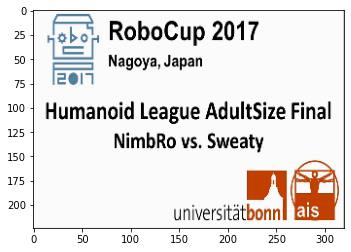

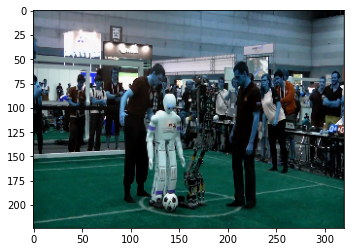

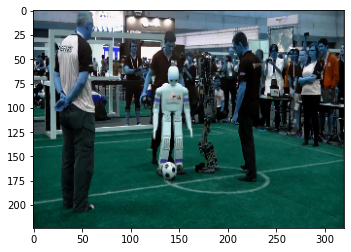

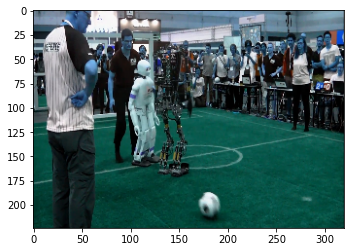

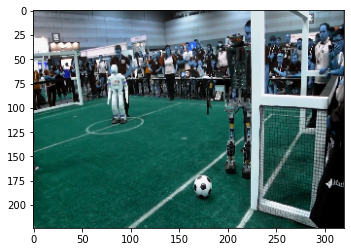

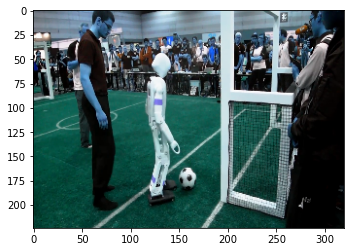

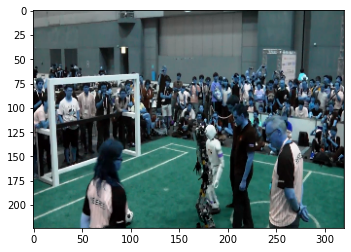

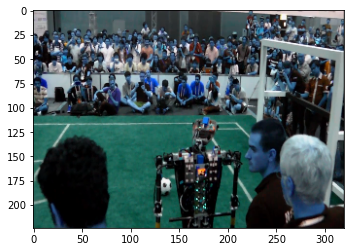

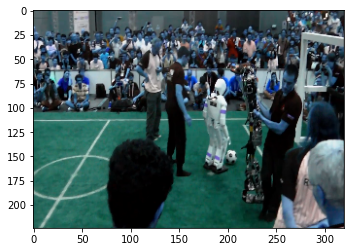

(9, 6, 3, 320, 224)
(6, 3, 2088, 657) 0 251 uint8
3 torch.Size([4, 6, 3, 320, 224]) torch.Size([4, 6, 3, 320, 224])


In [10]:
def createOutVols( tset, its, bt_size ):
    splits = np.arange( 0, len(its), bt_size )
    scan_it = 0
    vols = []
    for split in splits:
        out = []
        for b_it in range( min( bt_size, len(its)-split ) ):
            out.append( tset[its[scan_it]] )
            scan_it += 1
        vols.append( torch.stack( out, axis=0 ) )
    return vols
        
vis_vols = createOutVols( test, out_its, bt_size )

tr_logger = Logger( "train" )
ts_logger = Logger( "test" )

im_list = []
for vol in vis_vols:
    for bt_it in range( min( bt_size, len(vis_vols) ) ):
        im_list.append( vol[bt_it,:,:,:,:] )
        im = ((np.swapaxes( vol[bt_it,0,:,:,:], 0,2 )+1)*125.5).numpy().astype(np.uint8) 
        plt.imshow( im )
        plt.show()
im_list = np.stack( im_list, axis=0 )
print(im_list.shape)
gif = ts_logger._getGif( im_list, im_list )
print( gif.shape, gif.min(), gif.max(), gif.dtype ) 
#gifFunc( "test.gif", np.swapaxes( gif,1,3  ), fps=4 )

vis_vols = [v.to( device ) for v in vis_vols]
print( len(vis_vols), vis_vols[0].shape, vis_vols[-1].shape )

In [ ]:
model = PredictionModel(tr_set.width,tr_set.height)
model = model.to( device )
if not diff_lr: 
    param_group = model.parameters()
else:
    gru, conv = model.getParameterGroups()
    gru = list(itertools.chain.from_iterable(gru) )
    conv = list(itertools.chain.from_iterable(conv) )
    param_group = [ { "params": conv },
                    { "params": gru, "lr": lr[1], "weight_decay": l2_lambda[1] }]
optimizer = topt.Adam( param_group, lr=lr[0], weight_decay=l2_lambda[0] )
if load:
    print( "Loading: {}".format( load_pt ) )
    checkpoint = torch.load(load_pt)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler = topt.lr_scheduler.ReduceLROnPlateau( optimizer, factor=lrs_factor, patience=lrs_patience, 
                                                 threshold=lrs_thresh, verbose=True, min_lr=lrs_min,
                                                 cooldown=lrs_cd)

loss_func = SSIM( window_size=ssim_win_size ).to( device )
run = wandb.init( project="project_predictvideo", entity="cudavisionlab", name=name, reinit=True )

with run:
    wandb.config.lr = lr
    wandb.config.l2 = l2_lambda
    wandb.config.lrs = str(scheduler)
    wandb.config.ssim_ws = ssim_win_size
    wandb.config.seed = seed
    for epoch in range( num_epochs ):
        st_pt = time.time()
        tr_loss = np.array( 0.0 )
        run_loss = 0.0
        #model.train()
        for tr_it, seq in enumerate( train_loader ):        
            seq = seq.to( device )
            optimizer.zero_grad()
            out = model.predictSeq( seq[:,:3,:,:,:] )
            
            loss = torch.tensor(0.0).to( device )
            for im_it in range(3):
                cur_loss = (1-loss_func( seq[:,im_it+3,:,:,:], out[:,im_it,:,:,:] ))/2
                #print( im_it+3 )
                loss += cur_loss

            loss.backward()
            loss_cpu = loss.detach().clone().cpu().item()
            tr_loss += loss_cpu
            run_loss += loss_cpu
            optimizer.step()
            if (tr_it+1)%10 == 0: 
                print( "Epoch {}: {}/{}: Loss: {}".format( epoch+1, tr_it+1, len( train_loader ), tr_loss/(tr_it+1) ), end='\r' )
                if (tr_it+1)%100 == 0:
                    tr_logger.plotTr( run_loss /100, optimizer.param_groups[0]['lr'], time.time() -st_pt )
                    st_pt = time.time()
                    scheduler.step( run_loss /100 )
                    run_loss = 0.0
            del loss, cur_loss
            del seq, out
            
            if (tr_it+1)%test_inc == 0: 
                ts_st_pt = time.time()
                bt_loss = np.array( 0.0 )
                losses = np.zeros( 3 )
                #model.eval()
                seq_real = []
                seq_out = []
                with torch.no_grad():
                    for vol in vis_vols:
                        out = model.predictSeq( vol[:,:3,:,:,:] )
                        for b_it in range( vol.shape[0] ):
                            seq_real.append( vol[b_it,:,:,:,:].cpu().numpy() )
                            seq_out.append( out[b_it,:,:,:,:].cpu().numpy() )
                    del out
                    ts_logger.plotImages( np.stack( seq_real, axis=0 ), 
                                          np.stack( seq_out, axis=0 ), 
                                          epoch=tr_logger.cur_ep )
                    
                    for ts_it, seq in enumerate( test_loader ):  
                        seq = seq.to( device )
                        out = model.predictSeq( seq[:,:3,:,:,:] )

                        loss = torch.tensor(0.0).to( device )
                        for im_it in range(3):
                            cur_loss = (1-loss_func( seq[:,im_it+3,:,:,:], out[:,im_it,:,:,:] ))/2
                            loss += cur_loss
                            losses[im_it] += cur_loss.detach().clone().cpu().item()

                        bt_loss += loss.detach().clone().cpu().item()
                        if (ts_it+1)%10 == 0: 
                            print( "Epoch {}: Testing {}/{}: Loss: {}".format( epoch+1, ts_it+1, len( test_loader ), bt_loss/(ts_it+1) ), end='\r' )
                        del loss, cur_loss
                        del seq, out

                    print( "Epoch {}: Test Loss {}".format( epoch+1, bt_loss /len(test_loader) ), end='\r' )    
                    ts_logger.plot( bt_loss /len(test_loader), losses /len(test_loader), time.time() -ts_st_pt, epoch=tr_logger.cur_ep )
                    ts_logger.plotImages( np.stack( seq_real, axis=0 ), 
                                          np.stack( seq_out, axis=0 ), 
                                          epoch=tr_logger.cur_ep )
                #model.train()
            
            st_pt = time.time()
        #tr_logger.plot( tr_loss /len(train_loader), losses /len(train_loader), time.time() -st_pt )
        print( "Epoch {}: Loss {}".format( epoch+1, tr_loss /len(train_loader) ) )

torch.save(model.state_dict(), "./project/nets/{}".format( name ) )

wandb: Currently logged in as: thehorn93 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [12]:
torch.save({'seed': seed,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() },
            "./project/nets/{}.to".format( name ) )
print( "Saved: ./project/nets/{}.to".format( name ) )

Saved: ./project/nets/Robot_pred_lrss-4,2-4_l21-4,1-4_dec75.to


In [13]:
print(optimizer.state_dict())

{'state': {0: {'step': 219037, 'exp_avg': tensor([[[[-1.2878e-04]],

         [[-2.8261e-04]],

         [[-2.3919e-10]],

         ...,

         [[-1.5924e-04]],

         [[-8.9121e-05]],

         [[-4.1973e-04]]],


        [[[-3.1605e-05]],

         [[-3.9353e-05]],

         [[ 2.4837e-11]],

         ...,

         [[ 4.1850e-05]],

         [[-2.7361e-05]],

         [[-5.6497e-05]]],


        [[[-6.8974e-08]],

         [[-1.2669e-07]],

         [[ 1.6475e-13]],

         ...,

         [[-6.6439e-08]],

         [[ 4.3450e-08]],

         [[ 2.1124e-07]]],


        ...,


        [[[ 4.7788e-08]],

         [[ 1.8005e-07]],

         [[-8.4438e-14]],

         ...,

         [[ 3.0404e-08]],

         [[ 4.1568e-08]],

         [[ 1.7916e-08]]],


        [[[-8.7069e-06]],

         [[-1.4616e-05]],

         [[-8.4806e-12]],

         ...,

         [[-9.9489e-06]],

         [[-1.9049e-06]],

         [[-1.1643e-05]]],


        [[[ 1.3114e-07]],

         [[ 3.8985e-0

In [18]:
model = PredictionModel(tr_set.width,tr_set.height)
model = model.to( device )

if load:
    print( "Loading: {}".format( load_pt ) )
    checkpoint = torch.load(load_pt)
    model.load_state_dict(checkpoint['model_state_dict'])

err = 0.0
bt_loss = np.array( 0.0 )
with torch.no_grad():
    for ts_it, seq in enumerate( testvid_loader ):  
        seq = seq.to( device )
        out = model.predictSeq( seq[:,:3,:,:,:] )

        loss = torch.tensor(0.0).to( device )
        for im_it in range(3):
            cur_loss = (1-loss_func( seq[:,im_it+3,:,:,:], out[:,im_it,:,:,:] ))/2
            loss += cur_loss
            losses[im_it] += cur_loss.detach().clone().cpu().item()

        bt_loss += loss.detach().clone().cpu().item()
        if (ts_it+1)%10 == 0: 
            print( "Epoch {}: Testing {}/{}: Loss: {}".format( epoch+1, ts_it+1, len( test_loader ), bt_loss/(ts_it+1) ), end='\r' )
        del loss, cur_loss
        del seq, out
print( "Test video loss: {}".format(bt_loss/(ts_it+1)) )

Loading: ./project/nets/Robot_pred_lrss-4,2-4_l21-4,1-4_cont.to
Test video loss: 0.3165376292141538531674620770050545
